Data loaded from: KiwiData.pkl
Mask loaded from: mask.npy
Mask shape: (1024, 1392), 1179766 pixels selected (82.77%)
Found data cube at data.300.0.cube: shape=(1024, 1392, 26)
Found data cube at data.300.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.310.0.cube: shape=(1024, 1392, 26)
Found data cube at data.310.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.320.0.cube: shape=(1024, 1392, 26)
Found data cube at data.320.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.330.0.cube: shape=(1024, 1392, 26)
Found data cube at data.330.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.340.0.cube: shape=(1024, 1392, 26)
Found data cube at data.340.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.350.0.cube: shape=(1024, 1392, 26)
Found data cube at data.350.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.360.0.cube: shape=(1024, 1392, 28)
Found data cube at data.360.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.370.0

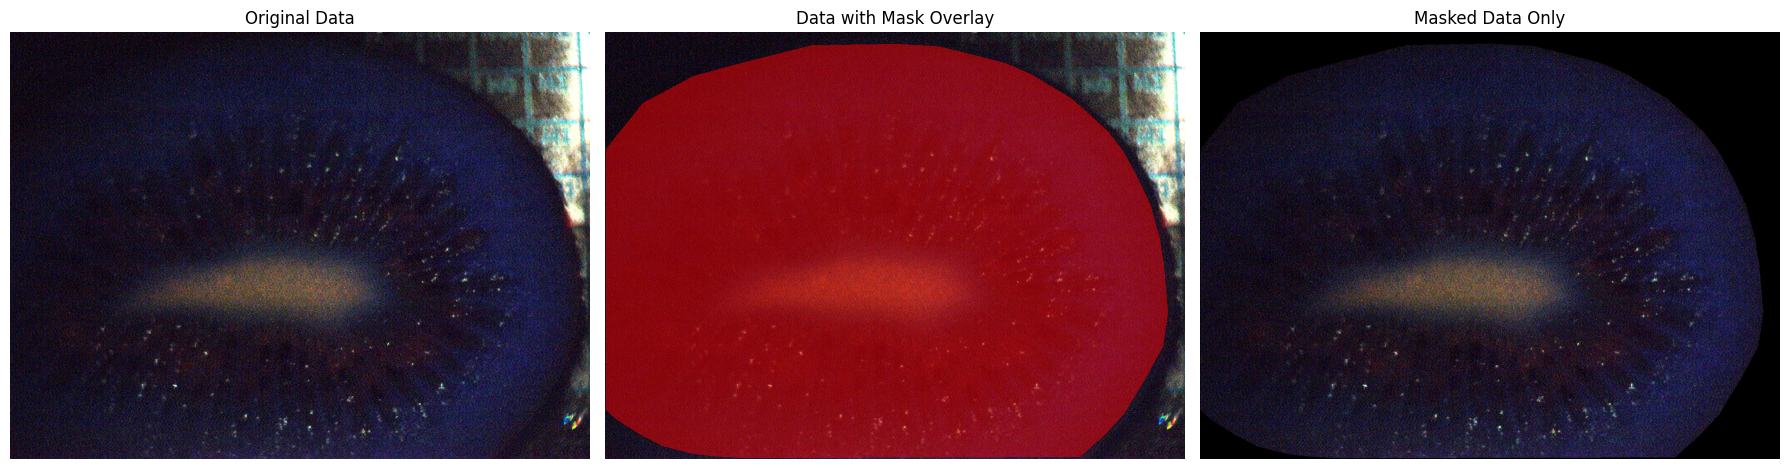

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import numpy as np
import pickle
import os
import copy
import traceback


def load_data_and_mask(data_path, mask_path):
    """
    Load hyperspectral data and mask.

    Args:
        data_path: Path to the hyperspectral data pickle file
        mask_path: Path to the mask npy file

    Returns:
        data_dict: The loaded hyperspectral data dictionary
        mask: The loaded mask array
    """
    # Load the data
    with open(data_path, 'rb') as f:
        data_dict = pickle.load(f)

    # Load the mask
    mask = np.load(mask_path)

    print(f"Data loaded from: {os.path.basename(data_path)}")
    print(f"Mask loaded from: {os.path.basename(mask_path)}")
    print(f"Mask shape: {mask.shape}, {np.sum(mask)} pixels selected ({np.sum(mask)/mask.size*100:.2f}%)")

    return data_dict, mask

def find_data_cubes(data_dict):
    """Find all 3D data cubes in the data structure."""
    cubes = {}

    def _find_cubes(data, path='', max_depth=5, current_depth=0):
        if current_depth >= max_depth:
            return

        if isinstance(data, dict):
            for key, value in data.items():
                current_path = f"{path}.{key}" if path else key

                # Check if this is a data cube (3D numpy array)
                if isinstance(value, np.ndarray) and len(value.shape) == 3:
                    # Store the cube
                    cubes[current_path] = value
                    print(f"Found data cube at {current_path}: shape={value.shape}")

                # Recursively search nested structures
                if isinstance(value, (dict, list)):
                    _find_cubes(value, current_path, max_depth, current_depth + 1)

        elif isinstance(data, list) and len(data) > 0:
            # For lists, check the first item
            current_path = f"{path}[0]"
            if isinstance(data[0], (dict, list, np.ndarray)):
                _find_cubes(data[0], current_path, max_depth, current_depth + 1)

    _find_cubes(data_dict)
    return cubes

def create_rgb_image(cube, method='rgb', percentile=99):
    """
    Create an RGB representation from a hyperspectral data cube.

    Args:
        cube: The data cube
        method: Method for creating RGB ('rgb', 'max', 'mean')
        percentile: Percentile for scaling

    Returns:
        RGB image as numpy array
    """
    # Check cube dimensions
    if len(cube.shape) == 3:
        # Identify which dimension is the spectral dimension
        if cube.shape[0] < cube.shape[1] and cube.shape[0] < cube.shape[2]:
            # First dimension is smallest, likely spectral bands
            bands_dim = 0
            height_dim = 1
            width_dim = 2
            print("Cube format: (bands, height, width)")
        elif cube.shape[2] < cube.shape[0] and cube.shape[2] < cube.shape[1]:
            # Last dimension is smallest, likely spectral bands
            bands_dim = 2
            height_dim = 0
            width_dim = 1
            print("Cube format: (height, width, bands)")
        else:
            # Assume standard format
            bands_dim = 0
            height_dim = 1
            width_dim = 2
            print("Assuming cube format: (bands, height, width)")
    else:
        raise ValueError(f"Unexpected cube shape: {cube.shape}. Expected 3D array.")

    # Replace NaN values
    cube = np.nan_to_num(cube)

    # Create RGB based on method
    if method == 'rgb':
        # Use three wavelengths as RGB channels
        num_bands = cube.shape[bands_dim]
        if num_bands >= 3:
            indices = [int(num_bands * 0.2), int(num_bands * 0.5), int(num_bands * 0.8)]
            r_idx, g_idx, b_idx = indices

            # Extract band images
            if bands_dim == 0:
                r_band = cube[r_idx, :, :]
                g_band = cube[g_idx, :, :]
                b_band = cube[b_idx, :, :]
            else:  # bands_dim == 2
                r_band = cube[:, :, r_idx]
                g_band = cube[:, :, g_idx]
                b_band = cube[:, :, b_idx]

            # Normalize to range [0, 1]
            r_scaled = r_band / np.percentile(r_band, percentile)
            g_scaled = g_band / np.percentile(g_band, percentile)
            b_scaled = b_band / np.percentile(b_band, percentile)

            # Clip to [0, 1] range
            r_scaled = np.clip(r_scaled, 0, 1)
            g_scaled = np.clip(g_scaled, 0, 1)
            b_scaled = np.clip(b_scaled, 0, 1)

            # Create RGB image
            rgb = np.stack([r_scaled, g_scaled, b_scaled], axis=2)
        else:
            # Default to max projection if not enough bands
            method = 'max'

    if method in ['max', 'mean']:
        # Generate a projection
        if bands_dim == 0:
            if method == 'max':
                proj = np.max(cube, axis=0)
            else:  # mean
                proj = np.mean(cube, axis=0)
        else:  # bands_dim == 2
            if method == 'max':
                proj = np.max(cube, axis=2)
            else:  # mean
                proj = np.mean(cube, axis=2)

        # Scale and clip
        max_val = np.percentile(proj[~np.isnan(proj)], percentile)  # Exclude NaNs for percentile
        scaled = proj / max_val if max_val > 0 else proj
        scaled = np.clip(scaled, 0, 1)

        # Replace NaNs with zeros
        scaled = np.nan_to_num(scaled)

        # Create RGB by duplicating the channel
        rgb = np.stack([scaled, scaled, scaled], axis=2)

    return rgb

def visualize_with_mask(data_dict, mask, excitation_key=None, method='rgb',
                        overlay_color='red', overlay_alpha=0.5, figsize=(18, 6)):
    """
    Create a visualization of the data with mask.

    Args:
        data_dict: The hyperspectral data dictionary
        mask: The mask array
        excitation_key: The excitation key to visualize (if None, uses the first one found)
        method: Method for creating RGB ('rgb', 'max', 'mean')
        overlay_color: Color of the mask overlay ('red', 'green', 'blue', 'yellow')
        overlay_alpha: Transparency of the mask overlay (0-1)
        figsize: Figure size

    Returns:
        fig, axes: The matplotlib figure and axes
    """
    # Find data cubes
    cubes = find_data_cubes(data_dict)

    if not cubes:
        raise ValueError("No suitable data cubes found in the data")

    # Select excitation key if not provided
    if excitation_key is None or excitation_key not in cubes:
        excitation_key = next(iter(cubes))
        print(f"Using excitation key: {excitation_key}")

    # Get the data cube
    cube = cubes[excitation_key]

    # Create RGB visualization
    rgb_image = create_rgb_image(cube, method=method)

    # Check mask dimensions
    if mask.shape[0] != rgb_image.shape[0] or mask.shape[1] != rgb_image.shape[1]:
        raise ValueError(f"Mask shape {mask.shape} doesn't match image shape {rgb_image.shape[:2]}")

    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # 1. Original data
    axes[0].imshow(rgb_image)
    axes[0].set_title("Original Data")
    axes[0].axis('off')

    # 2. Data with mask overlay
    axes[1].imshow(rgb_image)

    # Create mask overlay
    mask_overlay = np.zeros((*mask.shape, 4), dtype=np.float32)

    # Set color based on selection
    if overlay_color == 'red':
        mask_overlay[mask == 1, 0] = 1.0  # Red channel
    elif overlay_color == 'green':
        mask_overlay[mask == 1, 1] = 1.0  # Green channel
    elif overlay_color == 'blue':
        mask_overlay[mask == 1, 2] = 1.0  # Blue channel
    elif overlay_color == 'yellow':
        mask_overlay[mask == 1, 0] = 1.0  # Red channel
        mask_overlay[mask == 1, 1] = 1.0  # Green channel

    # Set transparency
    mask_overlay[mask == 1, 3] = overlay_alpha

    # Show overlay
    axes[1].imshow(mask_overlay)
    axes[1].set_title("Data with Mask Overlay")
    axes[1].axis('off')

    # 3. Masked data only
    masked_image = np.copy(rgb_image)

    # Set pixels outside mask to black
    for i in range(3):  # R, G, B channels
        channel = masked_image[:, :, i]
        channel[mask == 0] = 0

    axes[2].imshow(masked_image)
    axes[2].set_title("Masked Data Only")
    axes[2].axis('off')

    # Adjust layout
    plt.tight_layout()

    return fig, axes

# Example usage
# Modify these paths to point to your actual files
data_path = r'C:\Users\meloy\PycharmProjects\Capstone\Loader\Data\Kiwi Experiment\pickles\KiwiData.pkl'
mask_path = r'C:\Users\meloy\PycharmProjects\Capstone\Loader\Data\Kiwi Experiment\pickles\mask.npy'

# Load the data and mask
data_dict, mask = load_data_and_mask(data_path, mask_path)

# Create visualization
fig, axes = visualize_with_mask(data_dict, mask, method='rgb', overlay_color='red')
plt.show()

# You can also save the visualization
# fig.savefig('mask_visualization.png', dpi=300, bbox_inches='tight')

In [5]:
def create_masked_pickle(data_path, mask_path, output_path=None):
    """
    Create a new pickle file with masked hyperspectral data.

    Args:
        data_path (str): Path to the original hyperspectral data pickle file
        mask_path (str): Path to the mask .npy file
        output_path (str, optional): Output path for the masked data pickle file.
                                    If None, will use original filename + "_masked.pkl"

    Returns:
        str: Path to the saved masked data file
    """
    try:
        print(f"Loading data from {os.path.basename(data_path)}...")
        # Load the original data
        with open(data_path, 'rb') as f:
            data_dict = pickle.load(f)

        print(f"Loading mask from {os.path.basename(mask_path)}...")
        # Load the mask
        mask = np.load(mask_path)

        # Create a deep copy to avoid modifying the original
        masked_data = copy.deepcopy(data_dict)

        # Find data cubes in the structure
        print("Finding and masking data cubes...")
        cubes = find_data_cubes_with_paths(masked_data)

        # Check if mask is binary (0s and 1s)
        if not np.all(np.isin(mask, [0, 1])):
            print("Warning: Mask is not binary. Converting non-zero values to 1.")
            mask = (mask != 0).astype(np.uint8)

        # Get mask info
        masked_pixels = np.sum(mask)
        total_pixels = mask.size
        percent_masked = (masked_pixels / total_pixels) * 100
        print(f"Mask selects {masked_pixels} out of {total_pixels} pixels ({percent_masked:.2f}%)")

        # Apply mask to all data cubes
        masked_cubes = 0
        for cube_path, cube_info in cubes.items():
            try:
                # Apply mask to this cube
                apply_mask_to_cube(masked_data, cube_path, cube_info, mask)
                masked_cubes += 1
            except Exception as e:
                print(f"Error masking cube at {cube_path}: {str(e)}")

        print(f"Successfully masked {masked_cubes} data cubes")

        # Add mask information to metadata (if metadata exists)
        if isinstance(masked_data, dict) and 'metadata' in masked_data:
            masked_data['metadata']['mask_applied'] = True
            masked_data['metadata']['mask_path'] = mask_path
            masked_data['metadata']['mask_shape'] = mask.shape
            masked_data['metadata']['mask_sum'] = int(masked_pixels)
            masked_data['metadata']['mask_percentage'] = float(percent_masked)

        # Determine output path if not provided
        if output_path is None:
            base_path = os.path.splitext(data_path)[0]
            output_path = f"{base_path}_masked.pkl"

        # Save the masked data
        print(f"Saving masked data to {os.path.basename(output_path)}...")
        with open(output_path, 'wb') as f:
            pickle.dump(masked_data, f)

        print(f"Masked data saved successfully to {output_path}")
        return output_path

    except Exception as e:
        print(f"Error creating masked pickle: {str(e)}")
        traceback.print_exc()
        return None

def find_data_cubes_with_paths(data, path='', max_depth=5, current_depth=0):
    """
    Find all 3D data cubes in the nested data structure and return them with their paths.

    Returns:
        dict: Dictionary mapping paths to cube information
              {path: {'parent': parent_object, 'key': key, 'shape': shape}}
    """
    cubes = {}

    if current_depth >= max_depth:
        return cubes

    if isinstance(data, dict):
        for key, value in data.items():
            current_path = f"{path}.{key}" if path else key

            # Check if this is a data cube (3D numpy array)
            if isinstance(value, np.ndarray) and len(value.shape) == 3:
                # Store the cube with its path and parent object for easy access later
                cubes[current_path] = {
                    'parent': data,
                    'key': key,
                    'shape': value.shape,
                    'is_list': False,
                    'list_index': None
                }
                print(f"Found data cube at {current_path}: shape={value.shape}")

            # Recursively search nested structures
            if isinstance(value, (dict, list)):
                nested_cubes = find_data_cubes_with_paths(value, current_path, max_depth, current_depth + 1)
                cubes.update(nested_cubes)

    elif isinstance(data, list) and len(data) > 0:
        for i, item in enumerate(data):
            current_path = f"{path}[{i}]"

            # Check if this item is a data cube
            if isinstance(item, np.ndarray) and len(item.shape) == 3:
                cubes[current_path] = {
                    'parent': data,
                    'key': i,
                    'shape': item.shape,
                    'is_list': True,
                    'list_index': i
                }
                print(f"Found data cube at {current_path}: shape={item.shape}")

            # Recursively search nested structures
            if isinstance(item, (dict, list)):
                nested_cubes = find_data_cubes_with_paths(item, current_path, max_depth, current_depth + 1)
                cubes.update(nested_cubes)

    return cubes

def apply_mask_to_cube(data_dict, cube_path, cube_info, mask):
    """Apply mask to a specific data cube in the data structure."""
    parent = cube_info['parent']
    key = cube_info['key']
    is_list = cube_info.get('is_list', False)

    if is_list:
        # Get the cube from the list
        cube = parent[key]
    else:
        # Get the cube from the dictionary
        cube = parent[key]

    # Check the cube's shape
    if len(cube.shape) != 3:
        raise ValueError(f"Expected 3D array, got shape {cube.shape}")

    # Check if the cube might be transposed (common issue)
    # We expect the cube to have shape (bands, height, width) or (height, width, bands)
    if cube.shape[0] < cube.shape[1] and cube.shape[0] < cube.shape[2]:
        # First dimension is smallest, likely spectral bands - (bands, height, width)
        bands_dim = 0
        height_dim = 1
        width_dim = 2
    elif cube.shape[2] < cube.shape[0] and cube.shape[2] < cube.shape[1]:
        # Last dimension is smallest, likely spectral bands - (height, width, bands)
        bands_dim = 2
        height_dim = 0
        width_dim = 1
    else:
        # Hard to tell, assume standard (bands, height, width)
        bands_dim = 0
        height_dim = 1
        width_dim = 2

    # Check mask dimensions match spatial dimensions of the cube
    cube_height = cube.shape[height_dim]
    cube_width = cube.shape[width_dim]

    if mask.shape[0] != cube_height or mask.shape[1] != cube_width:
        raise ValueError(f"Mask shape {mask.shape} doesn't match cube spatial dimensions ({cube_height}, {cube_width})")

    # Create masked version
    masked_cube = np.copy(cube)

    # Apply mask (set non-masked values to NaN)
    if bands_dim == 0:
        # For each band, apply mask to the 2D image
        for i in range(cube.shape[bands_dim]):
            # Set values outside mask to NaN
            masked_cube[i][mask == 0] = np.nan
    elif bands_dim == 2:
        # For (height, width, bands) format
        for i in range(cube.shape[bands_dim]):
            # Need to use advanced indexing for this format
            mask_indices = np.where(mask == 0)
            masked_cube[mask_indices[0], mask_indices[1], i] = np.nan

    # Update the cube in the data structure
    if is_list:
        parent[key] = masked_cube
    else:
        parent[key] = masked_cube

    return True

data_path = r'C:\Users\meloy\PycharmProjects\Capstone\Loader\Data\Kiwi Experiment\pickles\KiwiData_normalized_exposure_down.pkl'
mask_path = r'C:\Users\meloy\PycharmProjects\Capstone\Loader\Data\Kiwi Experiment\pickles\mask.npy'

masked_file = create_masked_pickle(data_path, mask_path, output_path='../Data/Kiwi Experiment/pickles/masked_KiwiData_normalized_exposure_down.pkl')

Loading data from KiwiData_normalized_exposure_down.pkl...
Loading mask from mask.npy...
Finding and masking data cubes...
Found data cube at data.300.0.cube: shape=(1024, 1392, 26)
Found data cube at data.300.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.310.0.cube: shape=(1024, 1392, 26)
Found data cube at data.310.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.320.0.cube: shape=(1024, 1392, 26)
Found data cube at data.320.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.330.0.cube: shape=(1024, 1392, 26)
Found data cube at data.330.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.340.0.cube: shape=(1024, 1392, 26)
Found data cube at data.340.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.350.0.cube: shape=(1024, 1392, 26)
Found data cube at data.350.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data.360.0.cube: shape=(1024, 1392, 28)
Found data cube at data.360.0.raw.data: shape=(1024, 1392, 31)
Found data cube at data